# <center/> Basics of Mobile Robotics 
### <center/> Project with Thymio Robot

***
__<p style='text-align: left;'> Group members & Sciper</p>__ 
Tom Mery               297217
<br/> Lola Vegeas      301582<br/> 
Jean Decroux           302762
<br/> Ramy Charfeddine 295758 <br/>
***

# 1 Introduction

The main purpose of this jupyter notebook is to provide all the information necessary to run the overall project as well as to present the theory behind the implementation. To directly run the project please refer to section **Instructions to run the project**.

Recall that the objective was to control a Thymio robot. The Thymio has to go from an arbitrary position on the map to a target that can be placed anywhere in the environment. While navigating, the Thymio has to use local navigation to avoid physical obstacles that can be put in its path at any point in time. 

## 1.1 Environment and main assumptions

The environment is made of a uniform background. Fixed obstacles are placed on top of this background and will be avoided by the Thymio using global navigation. These obstacles must all be of the same color and their color must be far enough from the average color of the background. It is preferable to use planar obstacles so that one can be sure the Thymio will avoid them using global navigation and not local navigation. These fixed obstacles can take any geometrical form. 

An example of the environment is provided below :

<br/>

![](./images/environment_example.jpeg)
    
<br/>

A camera is mounted above the environment in order to find the fixed obstacles and track the Thymio during the motion. The camera has to be as parallel as possible with the environment to provide accurate results. It was chosen to use a smartphone camera using IVcam software. The implementation supports also any other webcam.

The Thymio is controlled using an asynchronous method provided by ClientAsync object from tdmclient package. The set up is reactive enough to use wireless connection with the Thymio. The top surface of the Thymio needs to be uniform with exactly one geometrical shape inside its contours. This shape needs to be placed such that the vector going from the center of this shape to the center of the Thymio describes the direction of the motion and the angle of the Thymio. An example of the Thymio's top surface is presented below :

<br/>

![](./images/thymios_top.jpg)

<br/>


## 1.2 Instructions to run the project

Once the environment is created and the camera is mounted as described before the overall project can be launched by running the jupyter notebook "**main.ipynb**" available in the same folder as this one. In this notebook the user is asked to complete multiple tasks in order to set up the environment. Here are presented the main steps :
- Import the necessary packages and functions by running the 1st cell
- Get the node of the Thymio using ClientAsync from tdmclient  by running the 2nd cell
- Place a rectangle horizontally with an area of 1/4 of an A4 sheet on the environment
- Select the bounding box containing the rectangle by running the 3d cell (this step is used to map any distance given in meter units to pixel units)
- Remove the rectangle from the background
- Define the main function by running the 4th cell
- Place the Thymio on the environment at the desired starting position
- Call the main function by running the last cell
- Select on the first pop-up window a bounding box containing the Thymio
- Select on the second pop-up window the desired goal position 
- Select on the third pop-up window a bounding box containing the color of the background only
- A last pop-up window will appear to display the visibility graph and the found shortest path. Finally press "Q" on the keyboard if the path seems to be feasible. The Thymio will start his motion automatically.
- The code can be aborted at any time during the motion by pressing "Q".
- If the code is not aborted the motion will stop when the Thymio reaches the goal. 

A quick demo and a tutorial to run the code are available in the folder "videos".

# 2 State diagram
The simplified state diagram is presented below :
<br/>

![](./images/state_diagram.png)

<br/>

In the following sections the steps of the state diagram are presented separately. Only the main steps and the theory necessary to understand the process are presented here. More details about the implementation regarding the obstacle detection, the path planning, the local avoidance, the path following, as well as the extraction of the Thymio state are available respectively in "**obtascle_detection.py**", "**path_planning.py**", "**local_avoidance.py**", "**path_following.py** and "**thymio_state.py**" python files. 

# 3 Obstacle detection
More detail about the implementation of this part are available in the python file "**obtascle_detection.py**".

The fixed obstacles present in the environment are extracted from the first frame captured by the camera. First the initial frame needs to be pre-processed in order to remove the Thymio from the image. To do so the user is asked to select a bounding box containing the Thymio and a bounding box containing the background only. The average RGB value of the background is then computed and the RGB value of the pixels inside the box containing the Thymio are replaced by the average background color. From this pre-processed image the following steps are done to find the contour of the obstacles :
- The image is blurred using average kernel of size 11x11
- A pixel clustering using K-means algorithm is applied in order to quantize the image with only two colors (hyper-parameter K=2 since it is assumed that all the obstacles have the same color and the background does not have the same color than the obstacles) 
- Image is converted to grayscale 
- Gaussian kernel of 5x5 is applied to remove possible noise coming from the color quantization
- Edges of the obstacles are detected using Canny filtering
- Contours are found from the edges using Opencv function "findContours"
- Contours are approximated has polygons with a precision of 1% of their perimeter
- Convex hull of these approximations are computed (this step will be usefull when creating the visibility graph : it will remove unnecessary edges and make the search of crossing edges easier (no need to check the concavity of every obstacles))
- Contours of the convex hulls are expanded by half of the width of the Thymio
- Finally the contours are parsed as a list of polygon objects

All these steps are implemented by the function "find_obstacles" in the python file "**obtascle_detection.py**" :

In [1]:
import cv2 as cv
import imutils
from obstacle_detection import color_quantization, expand_contour, parse_contours

def find_obstacles(img, number_of_colors, m2pix_coeff):
    image = img.copy()
    
    # Blur the image with average kernel 
    image = cv.blur(image, (11, 11))
    
    # Pixel clustering using K-means
    image = color_quantization(image, number_of_colors)
    
    # Convert image to grayscale 
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # Blur slightly the image 
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    
    # Edges detection
    edges = cv.Canny(blurred, 100, 200)
    
    # Find contours from edges  
    cnts = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Approximate and expand the contour
    approx = []
    for c in cnts:
        peri = cv.arcLength(c, True)
        c = cv.approxPolyDP(c, 0.01 * peri, True)   # Approximate contour in polygon to reduce number of nodes 
        approx.append(cv.convexHull(c))     # Create convex hull of the polygon to avoid concave object in visibility graph
        approx[-1], color = expand_contour(approx[-1], m2pix_coeff)
        cv.drawContours(img, [approx[-1]], -1, color, 2) # not necessarry, only to check contour expansion
    
    # Parse contours of obstacle 
    obstacles = parse_contours(approx)
    return obstacles

# 4 Visibility graph

From the list of polygons returned by the function "find_obstacles" a visibility graph is mapped in order to find the shortest path from the start to the goal. The visibility graph consists of mapping every node of the graph (vertices of the obstacles + start + goal) with every visible node. A node is considered to be visible by another one when the segment that links these two nodes does not cross any obstacle contour. Thus the visibility graph is composed of a list of nodes (tuple : (x, y)) and a list edges (tuple : (index node1, index node2)). The edges of the visibility graph link two visible nodes. To find these edges the "brut-force" method consisting of testing every pair of possible segment that links two nodes of the graph is used. This algorithm has a complexity of N*(N-1) and a faster version exists but considering the number of nodes, the running time is acceptable. 

This algorithm is implemented by the function "get_graph_features" in the python file "**path_planning.py**" : 

In [2]:
from path_planning import is_edge_crossing, is_seg_inside_obstacle

def get_graph_features(start, obstacles, goal):
    nodes = []
    edges = [] 
    for poly in obstacles:
        nodes = nodes + poly.vertices
    nodes.append(goal)
    nodes.append(start)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            seg = [nodes[i], nodes[j]]
            if is_edge_crossing(seg, obstacles):
                continue
            if is_seg_inside_obstacle(seg, obstacles):
                continue
            else:
                edges.append((i, j))
    return nodes, edges

The result of the algorithm on the proposed environment with a start at pixel position (top, left) and a goal at pixel position (bottom, right) is available by running the next cell:

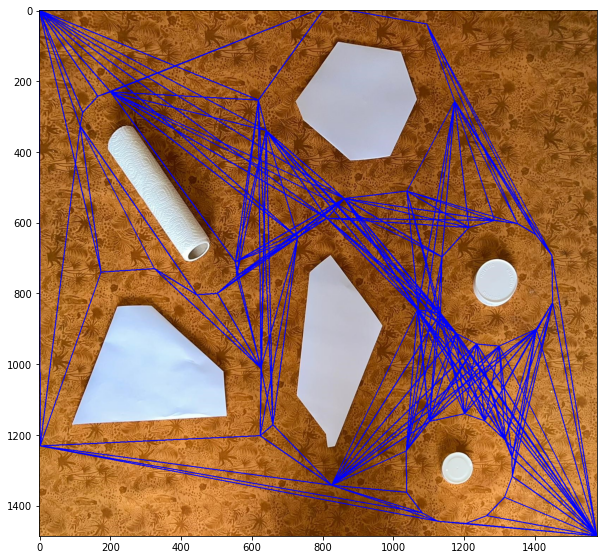

In [3]:
from obstacle_detection import find_obstacles
from path_planning import get_graph_features
import matplotlib.pyplot as plt
import numpy as np

# Load th image :
image = plt.imread("images/environment_example.jpeg")

# Find obstacles and expand them by half of the thymio size:
obstacles = find_obstacles(image, number_of_colors = 2, m2pix_coeff = 1000)

# Create the visibility graph :
start = (0, 0)
h, w = np.shape(image)[0:2]
goal = (w-1, h-1)
nodes, edges = get_graph_features(start, obstacles, goal)

# Draw visibility graph :
visibility_graph = image.copy()
for edge in edges :
    cv.line(visibility_graph, nodes[edge[0]], nodes[edge[1]], (0,0,255), 2)
fig = plt.figure(figsize=(10,30))
plt.imshow(visibility_graph)

# 5 Path planning

The path planning method that has been chosen for this project relies on the Dijkstra Algorithm. Based on graph search theory, it is widely used nowadays in a broad range of applications and is well understood and described, and related ressources are easily accessible, which partly explains our decision. Given the chosen set-up and the vision strategy, resorting to this algorithm came as logical.


## 5.1 Theory

Dijkstra's Algorithm aims at finding the optimal path according to a certain metric, in our case the minimum distance between 2 nodes, the initial and desired final position. Once the path planning algorithm is aware of the environment through a *Graph* object which encapsulates the information on the communicating nodes of the environment and the distance that separates two communicating nodes (or edges), and knows where the starting position is, it starts proceeding iteratively through the three following steps. First, starting with infinite distances at initialization, the "current node" is selected as the one with the lowest score related to our objective, here minimizing distance from the starting position, and one visits all of its neighbours. As we do so, we compute and update their tentative distance from the starting node. Once all of the neighbouring nodes have been visited and the corresponding distances updated, the node is marked as "visited" meaning that its final cost is known. The algorithm then jumps back to step 1 and loops until all the nodes have been visited. Once this is done, we know for each node the minimal distance required to reach it from the starting position (in *shortest_path*) as well as the previous node to reach it given the optimal trajectory delivering the shortest path (in *previous_nodes*). It allows us to reconstruct the optimal path starting from the goal and going backwards until the starting position.     

## 5.2 Implementation

During the starting phase of our implementation, a list of communicating nodes in the environnement resulting from obstacle contours as well as the corresponding distances separating two communicating nodes are outputted by the vision algorithms and are used by the path planning algorithm to return the shortest obstacle-free path on the map, in the form of a list of node coordinates *path_coords* for which the now obstacle-aware Thymio should pass by to reach the goal with the shortest travelled distance while avoiding the obstacles. Those nodes are then fed to the controller that will ensure that they are reached one at a time with the robot following the straight lines separating them. 

Note here that the functions *dijkstra_algorithm*, *print_result* and the class *Graph* are derived from Alexey Klochay implementation (with very few changes) that can be found on https://www.udacity.com/blog/2021/10/implementing-dijkstras-algorithm-in-python.html


## 5.3 Example 

The nodes and edges resulting from the above image are used here to illustrate the functioning and results of the path planning part of the project. Here is only presented the implementation of the *dijkstra_algorithm* and the class *Graph* for understanding purposes.

In [4]:
import sys

class Graph(object):    
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        self.graph = self.construct_graph(nodes, init_graph)
        
    def construct_graph(self, nodes, init_graph):
        '''
        This method makes sure that the graph is symmetrical. In other words, if there's a path from node A to B with a value V, there needs to be a path from node B to node A with a value V.
        '''
        graph = {}
        for node in nodes:
            graph[node] = {}
        
        graph.update(init_graph)
        
        for node, edges in graph.items():
            for adjacent_node, value in edges.items():
                if graph[adjacent_node].get(node, False) == False:
                    graph[adjacent_node][node] = value
                    
        return graph
    
    def get_nodes(self):
        "Returns the nodes of the graph."
        return self.nodes
    
    def get_outgoing_edges(self, node):
        "Returns the neighbors of a node."
        connections = []
        for out_node in self.nodes:
            if self.graph[node].get(out_node, False) != False:
                connections.append(out_node)
        return connections
    
    def value(self, node1, node2):
        "Returns the value of an edge between two nodes."
        return self.graph[node1][node2]

def dijkstra_algorithm(graph, start_node):
    unvisited_nodes = list(graph.get_nodes())
    
    # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
    shortest_path = {}
    
    # We'll use this dict to save the shortest known path to a node found so far
    previous_nodes = {}
    
    # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
    max_value = sys.maxsize
    for node in unvisited_nodes:
        shortest_path[node] = max_value
    # However, we initialize the starting node's value with 0   
    shortest_path[start_node] = 0
    
    # The algorithm executes until we visit all nodes
    while unvisited_nodes:
        # The code block below finds the node with the lowest score
        current_min_node = None
        for node in unvisited_nodes: # Iterate over the nodes
            if current_min_node == None:
                current_min_node = node
            elif shortest_path[node] < shortest_path[current_min_node]:
                current_min_node = node
        
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = graph.get_outgoing_edges(current_min_node)
        for neighbor in neighbors:
            tentative_value = shortest_path[current_min_node] + graph.value(current_min_node, neighbor)
            if tentative_value < shortest_path[neighbor]:
                shortest_path[neighbor] = tentative_value
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node
        
        # After visiting its neighbors, we mark the node as "visited"
        unvisited_nodes.remove(current_min_node)
    
    return previous_nodes, shortest_path

In the following cell, the function *find_path* is run from the python file path_planning with the list of obstacles found before and the obtained shortest path is displayed: 

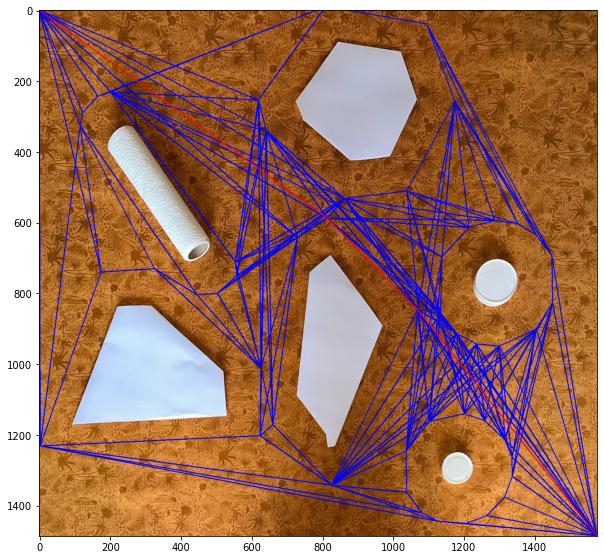

In [5]:
from path_planning import find_path

path_coords = find_path(start, obstacles, goal)

image_path = visibility_graph.copy()
# # Draw shortest path :
for i in range(len(path_coords)-1):
    cv.line(image_path, path_coords[i], path_coords[i+1], (255,0,0), 2)
fig = plt.figure(figsize=(10,30))
plt.imshow(image_path)

# 6 Thymio state

## 6.1 Measurement with the camera
The Thymio state is measured in real time by the camera. The state of the Thymio is described by its current position (x, y) in pixels on the frame and by its angle in radians that can vary from -$\pi$ to +$\pi$ (the positive direction of the angle is defined in the clockwise direction since the origin of an image corresponds to the top left corner). 

In order to get the state, the Thymio is tracked using the OpenCV CSRT tracker. More details about this tracker are available here : "https://arxiv.org/pdf/1611.08461.pdf". 
The initialisation of the tracker is available in the python file "**set_up.py**".
This tracker is able to return a bounding box containing the Thymio. 

Thus, the state of the Thymio is found using the bounding box provided by the tracker. First, the contours of the Thymio and the geometrical shape inside the contour of the Thymio are extracted from the current frame captured by the camera. To do so, the following steps are followed :
- Current frame is converted to gray scale
- A Gaussian blur with a kernel of 5x5 is applied
- Edges of the whole frame are extracted using Canny filtering
- The image containing the edges is converted to binary
- All the pixels outside of the bounding box returned by the tracker are set to zero using a simple AND operator with a mask where pixels inside the box are equal to 1, and 0 otherwise.
- Finally the contour of the Thymio and the geometrical shape on the top of the Thymio are extracted knowing that the contour of the Thymio has exactly one child and no parents and the contour of the geometrical shape has exactly one parent and no child (see OpenCV documentation about contour hierarchy and retrieval mode cv.RETR_TREE)

Given the contour of the Thymio and the contour of the geometrical shape the function "get_angle_and_center" in the python file "**thymio_state.py**" returns the center of the Thymio and its angle :

In [6]:
from math import atan2

def get_angle_and_center(thymio_contour, shape_contour):
    # Compute centroid of the Thymio :
    M = cv.moments(thymio_contour)
    center =  [int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])]
    
    # Compute centroid of the black rectangle :
    M = cv.moments(shape_contour)
    black_rect_pos =  [int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])]
    
    # Compute angle :
    v = [(center[0] - black_rect_pos[0]), (center[1] - black_rect_pos[1])]
    angle = atan2(v[1], v[0])
    
    return angle, center

The angle of the Thymio is simply the angle of the vector that goes from the center of the geometrical shape to the center of the Thymio from the horizontal. 

More details about the full implementation are available in "**thymio_state.py**".

## 6.2 Filtering

The state estimation is based on an **Extended Kalman Filter** (EKF). The choice of such filter lies in its rather easy numerical implementation and the fact that it maintains high level of optimality.  

In simple words, it comprises a prediction step where the mean and covariance are being computed according to the linearized model of motion followed by a correction step based on the measurements, and delivers a state estimate and the level of confidence we have of it. Note that throughout the following discussion, the major equations of the filter are used and that the whole theory behind them is not being discussed but can be found easily in corresponding textbooks.

The model that will be used has the following format (where the subscript k stands for evaluated at time $k \Delta t$):



$$\mathbf{x_k} = f(\mathbf{x_{k-1}},\mathbf{u_k}) + \mathbf{w_k}$$
$$\mathbf{y_k} = h(\mathbf{x_{k}},\mathbf{u_k}) + \mathbf{v_k}$$

- $\mathbf{x_k} \in R^n$ is the state vector  
- $\mathbf{u_k} \in R^m$ is the control input vector .
- $\mathbf{w_k} \in R^n$ is the process noise vector such that $\mathbf{w} \sim N(0,\mathbf{Q})$ is zero mean white Gaussian noise 
- $\mathbf{y_k} \in R^p$ is the output vector 
- $\mathbf{v_k} \in R^p$ is the measurement noise vector such that $\mathbf{v} \sim  N(0,\mathbf{R})$ is zero mean white Gaussian noise 


### 6.2.1 Time update

First, according to the EKF theory, the prediction step consists of the following two computations:

$$ \mathbf{\bar{x}_k} = f(\mathbf{x_{k-1}},\mathbf{u_k})$$
$$ \mathbf{\bar{P}_{k}} = \mathbf{F_k} \mathbf{P_{k-1}} \mathbf{F_k^T} + \mathbf{Q} $$

with $\mathbf{\bar{x}_k}$ the current prediction of the states, $\mathbf{x_{k-1}}$ the previous state estimate of the system and $\mathbf{u_k}$ the current input. $\mathbf{\bar{P}_{k}}$ is the covariance matrix of the predicted state, $\mathbf{P_{k-1}}$ of the previous estimate, $\mathbf{F_k}$ represents the dynamics of the system and
$\mathbf{Q}$ the constant covariance of the zero mean process noise.

One first needs to work out $\mathbf{F_k}$.

First note that the the states of our system are the horizontal and vertical positions *x* and *y* of the Thymio and the angle *$\theta$* that the Thymio does with the horizontal axis.
It could be written as: 

$$ \mathbf{x} = (x,y,\theta)$$

The inputs to our system are the right and left motor speeds, respectively $\dot{\phi_1}$ \& $\dot{\phi_2}$. 

$$ \mathbf{u} = (\dot{\phi_1},\dot{\phi_2})$$

Note that those two are being read directly from the motors in the real implementation.   

The dynamical model $\dot{\mathbf{x}} = f(\mathbf{x},\mathbf{u})$ of our system is the following (it will be detailed in the next section -Controller for the Thymio-):

$$ \dot{x} = \cos(\theta) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}$$
$$ \dot{y} = \sin(\theta) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}$$
$$ \dot{\theta} = \frac{\dot{\phi_2} r - \dot{\phi_1} r}{2 l}$$

with *r* the radius of the Thymio's wheels and *l* half of the length of the axle axis.

Discretizing with Euler method with a sampling period of $dt$, one has:

$$ x_{k} = x_{k-1} + dt \cos(\theta) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}$$
$$ y_{k} = y_{k-1} + dt \sin(\theta) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}$$
$$ \theta_{k} = \theta_{k-1} + dt \frac{\dot{\phi_2} r - \dot{\phi_1} r}{2 l}$$




It is thus clearly non-linear and that explains why the regular Kalman Filter (KF) cannot be used. One then goes ahead and linearizes the dynamical model about the previous state estimate to obtain the matrices $\mathbf{F_k}$ and $\mathbf{G_k}$. It yields 


$\mathbf{F_k} = \frac{\partial f}{\partial x} |_{x_{k-1},u_k} =$
\begin{bmatrix}
1 & 0 & - dt \sin(\theta_{k-1}) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}\\
0 & 1 & dt \cos(\theta_{k-1}) \frac{\dot{\phi_1} r + \dot{\phi_2} r}{2}\\
0 & 0 & 1
\end{bmatrix}

$\mathbf{G_k} = \frac{\partial f}{\partial u} |_{x_{k-1},u_k} =$
\begin{bmatrix}
dt \cos(\theta_{k-1}) \frac{r}{2} & dt \cos(\theta_{k-1}) \frac{r}{2} \\
dt \sin(\theta_{k-1}) \frac{r}{2} & dt \sin(\theta_{k-1}) \frac{r}{2} \\
-dt \frac{r}{2 l} & dt \frac{r}{2 l} 
\end{bmatrix}

Note that $\mathbf{G_k}$ is not used in the EKF theory.


Another point that needs to be covered is the characterization of the process noise covariance $\mathbf{Q}.$

To do so, we used the Thymio robot. For the $x$ and $y$ position, we reproduced a couple of times the same experiment consisting of measuring the distance that the robot covered in a fixed time interval and with a constant set velocity. We picked a time of 5s and right and left motor speeds of 50. We computed the standard deviation of the reached position and came up with a standard deviation for $(x,y)$ of $r1 = r2 = 0.0017$ (m). For $\theta$, one found $r3 = 0.1$ (rad) in the same spirit based on std of the Thymio angle given fixed time and velocity. 


Now that everything is in place for the predicting step, one can carry on with the updating step accounting for the sensor input.


### 6.2.2 Measurement update

The outputs of our system are the 3 states, $x$, $y$, $\theta$ that are measured by the camera. Thus, for $\mathbf{y_k} = h(\mathbf{x_{k}},\mathbf{u_k}) + \mathbf{v_{k}} $ one simply has: 

$\mathbf{y} = $
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}

Thus, $h(\mathbf{x_k}) = \mathbf{H} \mathbf{x_k} $ with the constant matrix  $\mathbf{H}$:

$\mathbf{H} = $
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}


Additionally, the covariance of the measurement noise $\mathbf{R}$ is set to be :

$\mathbf{R} = $
\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0.05
\end{bmatrix}

These values are expressed in pixels and radians. 
Note that this covariance matrix is not easy to define as the measurements of the camera depend on numerous factors such as the light in the room, the height where it is positionned, the robot's speed etc. It is then really difficult to come up with a single value. 

Thus, the camera measurements are supposed to be highly reliable compared to the time update from the model.


The innovation $\mathbf{i_k}$ is computed as follows: 

$$ \mathbf{i_k} = \mathbf{y_k} - h(\mathbf{\bar{x}_k})$$


The Kalman gain $\mathbf{K_k}$ is derived as:

$$ \mathbf{S_k} = \mathbf{H} \mathbf{\bar{P}_k} \mathbf{H}^T + \mathbf{R}$$

$$ \mathbf{K_k} = \mathbf{\bar{P}_k} \mathbf{H}^T \mathbf{S_k}^{-1}$$


One can then finally compute:


$$ \mathbf{x_k} = \mathbf{\bar{x}_k} + \mathbf{K_k} \mathbf{i_k}$$

$$ \mathbf{P_k} = (\mathbf{I} - \mathbf{K_k} \mathbf{H_k}) \mathbf{\bar{P}_k}$$

### 6.2.3 Implementation

Through a threading, our  *kalman_filter* is called at each time step and is fed with the previous state estimate and convariance estimate and returns the current state and covariance as a result of the model prediction and the camera measurements. Thus, at each time step, it linearizes the non-linear system and follows the regular KF theory. The position and orientation of the robot freshly estimated will then be used by the controller together with the targeted position to generate the correponding control input.  

Please note that the camera returns the $(x,y)$ state in **pixels** (first two components of the argument $x_{meas}$, the third one being the Thymio's angle in radians) and are thus in pixels when they enter the function and the resulting computations and results are in pixels.

Please also note that the $speed$ argument (the two motor speeds) in the function is in $rad/s$ and has been converted as such from the motor readings. The conversion factor used is : 1 Thymio speed unit corresponds to $0.43478260869565216$ $[mm/s]$ or $0.43478260869565216e^{-3}$ $[m/s]$ and to $0.43478260869565216e^{-3}/r$ $[rad/s]$ for the wheels where *r* is the radius of the Thymio's wheels in $[m]$. 

Note that the Extended Kalman filter code structure is widely based on the *Solutions Week 8* from the 2021 Basics of mobile robotics course. 

### 6.2.4 Example

The function *kalman_filter* and *convert_m2pix*, *saturate_scalar*, *jacobianF* are being "showcased" in the following small example and are the exact ones used in the "big" implementation.

The Thymio is going in a $\pi/4$-oriented straight line given equal right and left motor speeds and an initial angle of $\pi/4$. Note that the measurements are being artificially generated. The purpose of this small example is simply to illustrate how the EKF fuses the prediction and measurement and this is interestingly observed for the first points of the plot.

In [7]:
def jacobianF(x, u, m2pix_coeff, ts):
    r = convert_m2pix(RADIUS, m2pix_coeff)
    
    F = np.array([[1.0, 0.0, -ts*np.sin(float(x[2]))*(u[0]*r + u[1]*r)/2.0],
                [0.0, 1.0, ts*np.cos(float(x[2]))*(u[0]*r + u[1]*r)/2.0],
                [0.0, 0.0, 1.0]]) 
    return F

In [8]:
def kalman_filter(speed, x_est_prev, P_est_prev, x_meas, m2pix_coeff, ts):
    
    r1 = convert_m2pix(0.0017, m2pix_coeff)
    r2 = convert_m2pix(0.0017, m2pix_coeff)
    r3 = 0.1 
    
    H = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
    
    Q = np.array([[r1, 0, 0],[0, r2, 0], [0, 0, r3]])
    R = np.array([[1,0,0],[0,1,0],[0,0,0.04]])
    
    l = convert_m2pix(LENGTH, m2pix_coeff)
    r = convert_m2pix(RADIUS, m2pix_coeff)
    
    F = jacobianF(x_est_prev, speed, r, ts)
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    x_est_a_priori = np.array([[0.0],[0.0],[0.0]])
    x_est_a_priori[0] = x_est_prev[0] + ts*np.cos(x_est_prev[2])*(speed[0]*r + speed[1]*r)/2.0
    x_est_a_priori[1] = x_est_prev[1] + ts*np.sin(x_est_prev[2])*(speed[0]*r + speed[1]*r)/2.0
    x_est_a_priori[2] = x_est_prev[2] + ts*(speed[1]*r - speed[0]*r)/(2*l)
    
    x_predict.append(x_est_a_priori)
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(F, np.dot(P_est_prev, F.T));
    P_est_a_priori = P_est_a_priori + Q if type(Q) != type(None) else P_est_a_priori
    
    y = np.array([x_meas]).T
    
    # innovation / measurement residual
    i = y - np.dot(H, x_est_a_priori)
    
    # measurement prediction covariance
    S = np.array(np.dot(H, np.dot(P_est_a_priori, H.T)) + R)
    
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)))
    
    # a posteriori estimate
    x_est = x_est_a_priori + np.dot(K,i)
    P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori))
    
    return x_est, P_est

In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from path_following import convert_m2pix

m2pix_coeff = 500 

ts = 5.0  # [s]
LENGTH = 5.5*10**(-2)  # [m]
RADIUS = 2.2*10**(-2)  # [m] 

thymio_speed_to_ms = 0.43478260869565216 * 10**(-3)
thymio_speed_to_rads = (0.43478260869565216 * 10**(-3))/RADIUS

speed_thymio = 100

speed_ms = np.array([100, 100]) * thymio_speed_to_ms
speed_rads = np.array([100, 100]) * thymio_speed_to_rads

# Just for the example
delta_L = ts*speed_ms[0]
delta_L = convert_m2pix(delta_L,m2pix_coeff)


x_predict = [np.array([[0.0], [0.0], [0.0]])]

x_est = [np.array([[0.0], [0.0], [0.0]])]
P_est = [1000 * np.ones(3)]

for k in tqdm(range(10)):
    
    x_meas = ((k+1)*delta_L, (k+1)*delta_L, np.pi/4)
    new_x_est, new_P_est = kalman_filter(speed_rads, x_est[-1], P_est[-1], x_meas, m2pix_coeff, ts)
    
    x_est.append(new_x_est)
    P_est.append(new_P_est)

100%|██████████| 10/10 [00:00<00:00, 1432.24it/s]


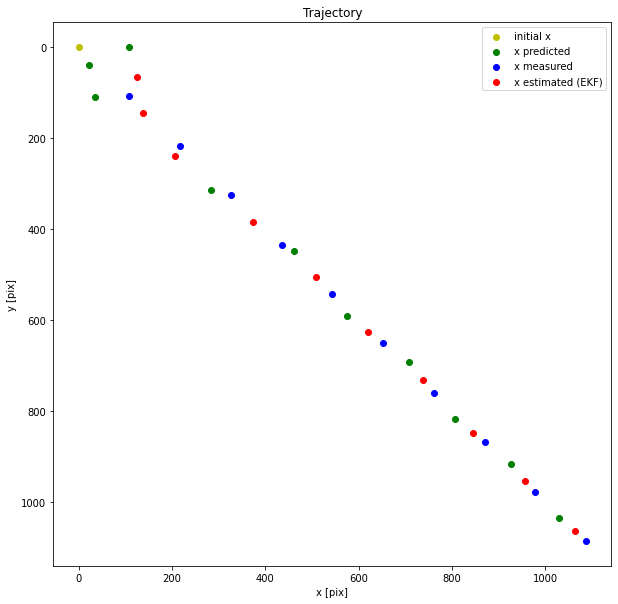

In [10]:
# Plot results :
plt.figure(figsize=(10,10))
plt.title("Trajectory")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

plt.scatter(0, 0, marker="o", color="y")

#plt.scatter(target_list[:,0], target_list[:,1], marker="o", color="r")
for i in range(len(x_est)-1):
    plt.scatter(x_predict[i+1][0], x_predict[i+1][1], marker="o", color="g")
    plt.scatter((i+1)*delta_L, (i+1)*delta_L, marker="o", color="b")
    plt.scatter(x_est[i+1][0], x_est[i+1][1], marker="o", color="r")

plt.legend(['initial x', 'x predicted','x measured', 'x estimated (EKF)'])
plt.gca().invert_yaxis()
#to fit what the vision gives us 

# 7 Path following (Controller for the Thymio)

In order to control the Thymio, the Astolfi controller was implemented. This relies on proportional control. The choice of this controller was motivated by its straightforward implementation on the robot and and because the model is rather intuitive. Furthermore, this control law smoothly modulates forward and rotational velocities.

The following derivation is inspired from the notes from lecture 1 of 2021 Basics of mobile robotics course.
## 7.1 Extracting the translational and rotational velocities from the Thymio 
The translational velocity of the robot is given by: $$\nu = \frac{r \dot{\phi_1}}{2}+\frac{r \dot{\phi_2}}{2}$$

The rotational velocity of the robot is given by: $$\omega = -\frac{r \dot{\phi_1}}{2l}+\frac{r \dot{\phi_2}}{2l}$$

Where $\phi_1$ is the velocity of the right motor, $\phi_2$ is the velocity of the left motor in $[rad/s]$, $r$ is the radius of the wheels and $l$ is the half width of the robot in pixels. The Thymio motor speeds can thus be expressed as a function of $\nu$ and $\omega$ as follows: 

$$\dot{\phi_1} = \frac{\nu}{r} - \frac{l \omega}{r}$$
$$\dot{\phi_2} = \frac{\nu}{r} + \frac{l \omega}{r}$$


## 7.2 Kinematic model in cartesian and polar coordinates
The global reference frame was chosen as shown in the image, with the y-axis pointing downwards. The angle of the robot was defined as positive clockwise and negative counter-clockwise in reference to the x-axis. 

The following model was obtained in the global frame (see the figure below): 

$$\dot{x} = \nu \cos{\theta} $$
$$\dot{y} = \nu \sin{\theta} $$
$$\dot{\theta} = \omega $$

Where $\theta$ is the angle of the robot with the horizontal axis and $x$ and $y$ are the cartesian coordinates of the thymio in the global frame. 


To simplify the model, it is transformed in polar coordinates with the origin at the goal position. This gives the following control law: 

$$\rho = \sqrt{\Delta x^{2} + \Delta y^{2}}$$
$$ \alpha = -\theta + \arctan{\left(\frac{\Delta y} {\Delta x}\right)}$$


$\rho$ is the distance from the current position of the Thymio to the goal in pixels, $\alpha$ is the angle between the direction of the Thymio and the line directly separating the Thymio from the goal, $\Delta x$ and $\Delta y$ are the distances separating the center of the robot to the goal (goal - position of the robot) in pixels. These two variables are illustrated in the figure below. 

The kinematic model in polar coordinates is then given by:

$$\dot{\rho} = -\nu \cos{\alpha}$$
$$\dot{\alpha} = \nu \frac{\sin{\alpha}}{\rho} - \omega$$

The linear control law is then given by: 
$$\nu = k_{\rho} \rho$$
$$ \omega = k_{\alpha} \alpha$$

Where $k_{\rho}$ and $k_{\alpha}$ are the gains for the inputs of the controller. 
Once these gains are set, the controller computes the motor speeds that need to be given to the Thymio that are a function of $\nu$ and $\omega$.

In closed loop the model in polar coordinates becomes: 

$$\dot{\rho} = -k_{\rho} \rho \cos{\alpha}$$
$$\dot{\alpha} = -k_{\alpha} \alpha + k_{\rho} \sin{\alpha}$$ 

This model has a unique equilibrium point at (0,0). The controller will thus always try to set $\alpha$ and $\rho$ to 0, thus aligning and driving the robot in the direction of the path lines.

<br/>

![](./images/thymio_model.png)

<br/>

## 7.3 Implementation of the Astolfi controller for the path following
Given the "absolute" start and "absolute" goal, the path planning delivers nodes or "intermediate" goals that the Thymio will track one at a time to reach its final desired position. Based on the visibility graph theory, the distance between two consecutive nodes is a straight line. Thus, the Thymio is controlled on each straight line of the visibilty graph consecutively. The control switches line as soon as the robot reaches an "intermediate" goal with a tolerance set at 30 pixels. 
However the Thymio tends to have a high speed at the beginning of the line and slows down when it reaches the end. 
To avoid a high speed difference every time the Thymio goes through a line, it was decided to discretize each line into sub-targets such that $\rho$ and thus $\nu$ would approximately stay constant until the goal is reached. To make sure that the robot does not stop at the end of each line of the path, the sub-targets are updated along the current line the robot is following until the robot reaches the end of it.   
## 7.4 Discretization of the path
For the discretization of the lines of the path, first of all, a desired speed for the Thymio is set (e.g. 200 in the example below), and the proportional gains in the control law are tuned such that the speed of the robot is approximately equivalent to the desired speed. Second of all, the lines are discretized such that at each sampling time, the target for the controller should approximately be updated of the distance $\Delta L$ that the Thymio covers during the sampling time. This is given by the following formula: 

$$\Delta L = \frac{L}{x}$$

Where $L$ is the total length of the current line in pixels and x is the number of divisions of the line. This number is an integer that is computed by rounding to an integer the result from the following formula: 

$$x = \frac{L}{T_s v_{des}}$$

Where, $T_s$ is the sampling time in $[s]$ and $v_{des}$ is the desired speed in $[pix/s]$. 
This discretization is done in the function "discretize_path" available in the python file "**path_following.py**". 
## 7.5 Tuning of the gains in the proportional control law
To ensure the stability of the model it is necessary that $k_{\alpha} > k_{\rho}$, and $k_{\rho} > 0$, using the Lyapunov theory. 
$k_{\alpha}$ and $k_{\rho}$ are then tuned such that the speed of the robot is approximatelely equal to the desired speed that is set for the path discretization and that the robot turns approximately at the same speed than when it is moving straight. 
The gains of the control law also have to be chosen such that the Thymio does not have a speed too high, because the motors saturate at a value of 500 and also the camera struggles to follow the robot if it moves too fast. 

## 7.6 Example to test the control law
Here is an example to test the implemented control law. In this example, the Thymio has to follow a line that makes an angle of $45^{\circ}$ with the horizontal, and the angle of the robot is initially set at $-90^{\circ}$ (it is vertically facing upwards in the graph). As expected, the robot turns gradually at the beginning, making a curve, to finally reach and follow the path until it reaches the goal.
If the gain $k_{\alpha}$ is increased, the Thymio will tend to turn faster and align itself with the path faster as it can be shown in the example by increasing the value of $k_{\alpha}$. 


In [11]:
from path_following import goal_reached, get_line_parameters, convert_m2pix, discretize_path, saturate_scalar
import numpy as np
import math
import matplotlib.pyplot as plt

LENGTH = 5.5*10**(-2)   # [m]  # half width of the thymio
RADIUS = 2.2*10**(-2)   # [m]  # wheel radius of the thymio 
THYMIO_SPEED_TO_RADS = (0.43478260869565216 * 10**(-3))/RADIUS 

In [12]:
def  Astolfi_controller(target, x, m2pix_coeff):
    x = np.squeeze(x)
    l = convert_m2pix(LENGTH, m2pix_coeff)
    r = convert_m2pix(RADIUS, m2pix_coeff)
    
    kp = 1
    kalpha = 2
    
    delta_x = target[0] - x[0]
    delta_y = target[1] - x[1]
    
    rho = np.linalg.norm(target - x[0:2])
    alpha = -x[2] + math.atan2(delta_y, delta_x)
    
    v = kp*rho
    w = kalpha*alpha
    
    phi1 = (v/r) - (l*w/r)
    phi2 = (v/r) + (l*w/r)
    
    phi1 = phi1/THYMIO_SPEED_TO_RADS
    phi2 = phi2/THYMIO_SPEED_TO_RADS
    
    phi1 = saturate_scalar(phi1, -500.0, 500.0)
    phi2 = saturate_scalar(phi2, -500.0, 500.0)
    
    return np.array([phi1, phi2])


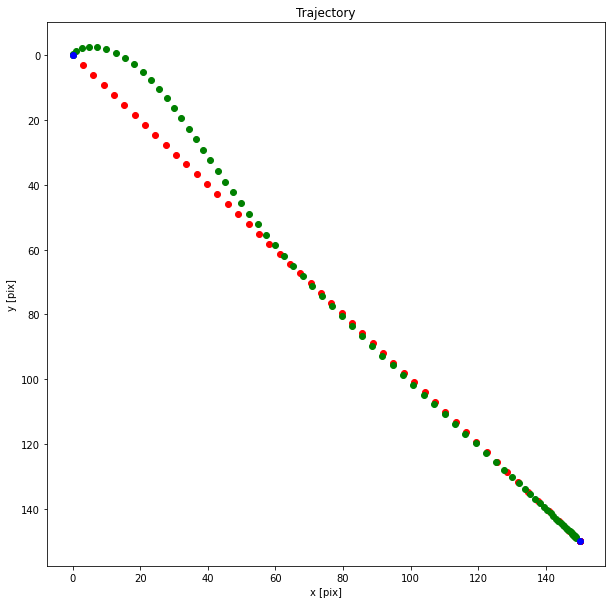

In [13]:
sampling_time = 0.1   #sampling period 
desired_speed = 200  #vitesse du thymio souhaitée (constante) 
tol = 1 
m2pix_coeff = 500

r = convert_m2pix(RADIUS,m2pix_coeff)
l = convert_m2pix(LENGTH,m2pix_coeff)

start_i = [np.array([0,0])]
goal_i = [np.array([150,150])]

length,theta = get_line_parameters(start_i[-1], goal_i[-1])

delta = discretize_path(length, convert_m2pix(desired_speed*THYMIO_SPEED_TO_RADS*RADIUS,m2pix_coeff), sampling_time)

x = [np.array([0.0,0.0,-np.pi/2])]

counter = 0
target_list = []
iter = 0

target_new = np.array([delta*np.cos(theta), delta*np.sin(theta)])
target_list.append(target_new)

while not goal_reached(goal_i[-1], tol, x[-1]):
    
    x_new = []
    
    vel_motors = Astolfi_controller(target_list[-1], x[-1], m2pix_coeff)
    vel_motors = vel_motors*THYMIO_SPEED_TO_RADS
    
    A = x[-1][0] + sampling_time*np.cos(x[-1][2])*(vel_motors[0]*r + vel_motors[1]*r)/2.0
    B = x[-1][1] + sampling_time*np.sin(x[-1][2])*(vel_motors[0]*r + vel_motors[1]*r)/2.0
    C = x[-1][2] - sampling_time*(vel_motors[0]*r - vel_motors[1]*r)/(2*l)
    
    x_new.append(A)
    x_new.append(B)
    x_new.append(C)
    
    x.append(x_new)
    
    if all(abs(target_new - goal_i[-1])<10**(-6)):
        pass 
    else: 
        target_new = target_new + np.array([delta*np.cos(theta), delta*np.sin(theta)])
    
    target_list.append(target_new)
    
    iter = iter + 1

# Plot results :
plt.figure(figsize=(10,10))
plt.title("Trajectory")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

for i in range(iter):
    plt.scatter(target_list[i][0], target_list[i][1], marker="o", color="r")
    plt.scatter(x[i][0], x[i][1], marker="o", color="g")

plt.scatter(start_i[-1][0], start_i[-1][1], marker="o", color="b")
plt.scatter(goal_i[-1][0], goal_i[-1][1], marker="o", color="b")
plt.gca().invert_yaxis()

# 8 Local avoidance

<br/>
<div style="text-align: justify"> The local navigation is an essential part to make the thymio robot more reactive and robust to its environment. Thus, the objective is to allow it to modulate its optimal trajectory to avoid unforseen, and unpredicted local obstacles. Nowadays, this behaviour is at the core of autonomous vehicles' motion control for instance. It would be indeed absurd to developp an autonomous car that only follows its predicted path without taking into account pedestrians. That's probably one of the most common future everyday's problem one will be faced to and which thymio tries to represent with the local navigation.</div> 

<br/>

<div style="text-align: justify"> The local navigation's implementation can be seperated into two subparts. First, one has to decide when the controller has to start avoiding local obstacles and eventually when to consider the unforseen obstacle as passed. Then, the controller has to make thymio behave as expected avoiding the obstacles.</div> 

More details about the full implementation of the local avoidance are available in the python file "**local_avoidance.py**"


## 8.1. Obstacle detection
<br/>

<div style="text-align: justify"> Ideally, in order to avoid having the robot missing the detection of unforseen obstacles, it should sense its environment continuously. However, in a driscretized real world, this is impossible and a sampling time has therefore to be chosen. Thus, knowing that the threading sampling time has been set to 0.1 sec, the thymio robot will be able to update his proximity sensors' value faster, each 0.01 sec as it has been chosen. Note that in order to keep information on the robot's state (position and angle) it's essential to continue the tracking while executing the local navigation.</div>

<br/>
   
<div style="text-align: justify"> The obstacle detection is mainly done thanks to the horizontal proximity sensors (5 in front and 2 at the back). As for this function, the sensors rely on infrared emiters that emit radiations which are then reflected back to the receiver. The particular electronics of the horizontal sensors filters the noisy ambient light and allows the distance measurement depending on the time the radiation takes to go back to the receiver photodiode after being reflected by the obstacle. It is thus, more intuitive to use white obstacles to have a better reflection and therefore better measurements. </div>

<br/>
     
<div style="text-align: justify"> Therefore, in order to determine whether the controller should start the obstacle avoidance or not, one should look at the value returned by the proximity sensors and compare it to the predefined threshold. If at least one of the sensors returns a value strictly greater than the threshold, one can consider that thymio is facing an unforseen obstacle and should run into the execution of the local avoidance. In the case of this project, it is expected to have the robot detect the obstacle as soon as possible and not get too close to it. Knowing that the values in the sensors array vary from 0 (the robot does not see anything) to several thousand (the robot is very close to an obstacle), the threshold is set to 0.</div>
   


## 8.2 Obstacle avoidance 

<br/>
<div style="text-align: justify"> Once the thymio has detected an unpredicted obstacle, it can then start avoiding it. In order to stay away from any misbehaviour due to other control blocks that try to interact with the robot, a higher importance is given to the local avoidance that has to occur at any time when needed. One of the easiest way to implement the obstacle avoidance algorithm is to use artificial neural networks (ANN).</div>
    
<br/>

<div style="text-align: justify"> ANN are based on a collection of connected nodes called artificial neurons. Each connection, can transmit a signal to other neurons after being processed by a predefined function. In order to implement complex functions, it is useful to form multiple layered ANN as well as weighting each connection. By doing so, the weights increase or decrease the strength of the signal at a connection. In this project, ANN is making a full connection between sensors and motors with a single layer of two neurons, as illustrated in the figure below . In other words by properly chossing the weights, it's possible to control each motor speed (left and right) depending on the value returned by the proximity sensors when detecting obstacles. Thus, each control speed is computed as follow </div>

\begin{array}{ll}
y_1 = f_1(x) = initial\_speed \cdot (1 + \displaystyle\sum_{i=1}^{7} w_{il} \cdot x_i) & \;\;\;\textrm{for the left wheel} \;\;\\
y_2 = f_2(x) = initial\_speed \cdot (1 + \displaystyle\sum_{i=1}^{7} w_{ir} \cdot x_i) & \;\;\;\textrm{for the right wheel} \;\;\\
\end{array} 
   
    
<br/>

![](./images/ANN_robot_control.png)

<br/>


<div style="text-align: justify"> The previous equation is at the core of the local avoidance algorithm and it is essential to get the idea behind it to understand the way the obstacle avoidance has been programmed. Hence, the main concept behind this implementation is to control the robot according to its closeness and poition to the unforseen obstacle. In other words, one knows that the closer the robot is to a given obstacle the higher will be the value returned by the closest sensor to that same obstacle. Therefore, by multiplying this sensor's value by a predefined weight, it is possible to give a higher value to one of the motors and therefore make thymio robot deviate from his initial trajectory to avoid the obstacle. Let's take an exemple to make it a bit more clear. </div>

<br/>

<div style="text-align: justify"> If for instance thymio was following a straight line and all of the sudden an unpredicted obstacle appears on his front right. Sensors x4 and x5 on the above figure will return a higher value than the remaining sensors. Then, by multiplying these values by the weights (knowing that they have been chosen symmetrically inversed for the left and right motor's control), a total higher value will be given to y2 and a smaller one to y1. By doing so, the right wheel will turn faster that the left one, making thymio deviate from his initial path and avoiding the obstacle by going a bit more on the left. Now, the question one can ask is obviously how do these weights have been chosen?
</div>

<br/>

<div style="text-align: justify"> Ideally, the weights' choice is done in two parts. First a rough initialization that makes the robot behave almost properly, then a correction done by reinforcing using the hebbian rule for instance. The Hebb rule is a great method to reinforce weights which have more influence on the good output. However, in this project, having only "easy" cases for the local navigation, the initialization has been chosen properly and ends up being sufficient to make thymio behave as expected. Therefore, no reinforcement method has been added. The weights are given as follow
    
<br/>

\begin{array}{ll}
[w_{1l},w_{2l},w_{3l},w_{4l},w_{5l},w_{6l},w_{7l}] = [2/3, 1/3, -3/2, -1/3, -2/3, 1, -1] & \;\;\;\textrm{for the left wheel} \;\;\\
[w_{1r},w_{2r},w_{3r},w_{4r},w_{5r},w_{6r},w_{7r}] = [-2/3, -1/3, -3/2, 1/3, 2/3, -1, 1] & \;\;\;\textrm{for the right wheel} \;\;\\
\end{array} 
</div>

<br/>

<div style="text-align: justify"> First, as one can notice, for each wheel the weights are symmetric around the middle sensor x3 but with an inverted sign. This is done in such a way that having an obstacle on the front right or the front left would lead to the same behaviour of the wheels in terms of speed. Then, having an inverted sign between the left and right wheel for all sensors, except the middle one, is to control the direction of rotation, so that both wheels do not rotate in the same direction but rather in opposite direction to make the robot deviate. Finally, the front sensor is given a higher negative weight to make the robot move backward faster in the case where an obstacle is right in front. Besides, the extreme sensors are given a weight twice higher as the one next to them in order to make the robot behave faster when it only sees an obtacle at its front extremity as there will be a higher chance that the other sensors didn't detect the obstacle and that the robot ends up closer to it. The front side sensors have a weight normalized by 3 to let their sum being equal to 1. That's not something mandatory to respect but it makes more sense to have a certain cohesion with the weights of the backward sensors.</div>

<br/>

<div style="text-align: justify"> Finally, once all the weights set, it's essential to normalize the output given to control the speed's wheels. Indeed, by experimenting one knows that the approximate range of the value returned by the proximity sensors is [0;5500]. Besides, the range of values given to the motor is [-500;500]. Therefore, in order to stay in the accepted range for the motors, one can normalize the output by the possible maximum value of the proximity sensors (~5000). In addition, multiplying the factor added to the initial speed by 3, is a tuning parameter that can be changed but that has been chosen as follow to keep a certain cohesion with the previous normalization of the front side sensors. The final wheel control equations are given as follow, but are of course not the unique nor optimal solution, but rather one that works well with the project that has been developped. </div>

<br/> 

\begin{array}{ll}
y_1 = f_1(x) = target\_speed + target\_speed \cdot \frac{3}{5000} \cdot \displaystyle\sum_{i=1}^{7} w_{il} \cdot x_i & \;\;\;\textrm{for the left wheel} \;\;\\
y_2 = f_2(x) = target\_speed + target\_speed \cdot \frac{3}{5000} \cdot \displaystyle\sum_{i=1}^{7} w_{ir} \cdot x_i & \;\;\;\textrm{for the right wheel} \;\;\\
\end{array}


# Conclusion 

To resume, we divided the project in 3 steps that were detailed above: 
- The path planning which consists of identifying the obstacles, and finding the optimal path from the initial position of the Thymio to the goal. 
- The state estimation of the robot, derived by applying an EKF based majorly on the camera measurements and also on the prediction from the model. This ensures an optimal estimation of the position of the robot.
- The path following which consists of applying the appropriate control on the Thymio motors. 
- The obstacle avoidance which ensures that the robot avoids any unpredicted obstacles by using its sensors. 

Overall this project was a great opportunity to introduce us to the world of robotics. It was a real challenge to get it to work all together, in different conditions. However, we were very happy with the final results, especially given all the work we put in to reach this point. It was also interesting to work as a group to overcome the obstacles we faced together (no local avoidance possible here :P) and develop the main ideas together. 